In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,Bidirectional,GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
import datetime
import io
import itertools
# import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import sys
import os
# Obtener la ruta del directorio actual
os.chdir('..')
current_dir = os.getcwd()
print(current_dir)

# Construir la ruta relativa al directorio que quieres agregar
relative_dir = os.path.join(current_dir, 'mis_pkgs/')

# Agregar la ruta relativa al sys.path
sys.path.insert(0, relative_dir)

from MIOPATIA_db import DB_management as db 


i:\nuevas_investigaciones_alimentos_2024


In [6]:
numero_muestras=401

Voy a quedarme con los 50 atunes P1 para obtener conjunto de training y validacion

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add, Activation, Concatenate, Conv2D, Dropout 
from tensorflow.keras.layers import Flatten, Input, GlobalAveragePooling2D, MaxPooling2D
import tensorflow.keras.backend as K

__version__ = '0.0.1'


def SqueezeNet(input_shape, nb_classes, use_bypass=False, dropout_rate=None, compression=1.0):
    """
    Creating a SqueezeNet of version 1.0
    
    Arguments:
        input_shape  : shape of the input images e.g. (224,224,3)
        nb_classes   : number of classes
        use_bypass   : if true, bypass connections will be created at fire module 3, 5, 7, and 9 (default: False)
        dropout_rate : defines the dropout rate that is accomplished after last fire module (default: None)
        compression  : reduce the number of feature-maps (default: 1.0)
        
    Returns:
        Model        : Keras model instance
    """
    
    input_img = Input(shape=input_shape)

    x = Conv2D(int(96*compression), (7,7), activation='relu', strides=(2,2), padding='same', name='conv1')(input_img)

    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool1')(x)
    
    x = create_fire_module(x, int(16*compression), name='fire2')
    x = create_fire_module(x, int(16*compression), name='fire3', use_bypass=use_bypass)
    x = create_fire_module(x, int(32*compression), name='fire4')
    
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool4')(x)
    
    x = create_fire_module(x, int(32*compression), name='fire5', use_bypass=use_bypass)
    x = create_fire_module(x, int(48*compression), name='fire6')
    x = create_fire_module(x, int(48*compression), name='fire7', use_bypass=use_bypass)
    x = create_fire_module(x, int(64*compression), name='fire8')
    
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool8')(x)
    
    x = create_fire_module(x, int(64*compression), name='fire9', use_bypass=use_bypass)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)
        
    x = output(x, nb_classes)

    return Model(inputs=input_img, outputs=x)


def SqueezeNet_11(input_shape, nb_classes, dropout_rate=None, compression=1.0):
    """
    Creating a SqueezeNet of version 1.1
    
    2.4x less computation over SqueezeNet 1.0 implemented above.
    
    Arguments:
        input_shape  : shape of the input images e.g. (224,224,3)
        nb_classes   : number of classes
        dropout_rate : defines the dropout rate that is accomplished after last fire module (default: None)
        compression  : reduce the number of feature-maps
        
    Returns:
        Model        : Keras model instance
    """
    
    input_img = Input(shape=input_shape)

    x = Conv2D(int(64*compression), (3,3), activation='relu', strides=(2,2), padding='same', name='conv1')(input_img)

    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool1')(x)
    
    x = create_fire_module(x, int(16*compression), name='fire2')
    x = create_fire_module(x, int(16*compression), name='fire3')
    
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool3')(x)
    
    x = create_fire_module(x, int(32*compression), name='fire4')
    x = create_fire_module(x, int(32*compression), name='fire5')
    
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='maxpool5')(x)
    
    x = create_fire_module(x, int(48*compression), name='fire6')
    x = create_fire_module(x, int(48*compression), name='fire7')
    x = create_fire_module(x, int(64*compression), name='fire8')
    x = create_fire_module(x, int(64*compression), name='fire9')

    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    
    # Creating last conv10
    x = output(x, nb_classes)

    return Model(inputs=input_img, outputs=x)


def output(x, nb_classes):
    x = Conv2D(nb_classes, (1,1), strides=(1,1), padding='valid', name='conv10')(x)
    x = GlobalAveragePooling2D(name='avgpool10')(x)
    x = Activation("softmax", name='softmax')(x)
    return x


def create_fire_module(x, nb_squeeze_filter, name, use_bypass=False):
    """
    Creates a fire module
    
    Arguments:
        x                 : input
        nb_squeeze_filter : number of filters of squeeze. The filtersize of expand is 4 times of squeeze
        use_bypass        : if True then a bypass will be added
        name              : name of module e.g. fire123
    
    Returns:
        x                 : returns a fire module
    """
    
    nb_expand_filter = 4 * nb_squeeze_filter
    squeeze    = Conv2D(nb_squeeze_filter,(1,1), activation='relu', padding='same', name='%s_squeeze'%name)(x)
    expand_1x1 = Conv2D(nb_expand_filter, (1,1), activation='relu', padding='same', name='%s_expand_1x1'%name)(squeeze)
    expand_3x3 = Conv2D(nb_expand_filter, (3,3), activation='relu', padding='same', name='%s_expand_3x3'%name)(squeeze)
    
    axis = get_axis()
    x_ret = Concatenate(axis=axis, name='%s_concatenate'%name)([expand_1x1, expand_3x3])
    
    if use_bypass:
        x_ret = Add(name='%s_concatenate_bypass'%name)([x_ret, x])
        
    return x_ret


def get_axis():
    axis = -1 if K.image_data_format() == 'channels_last' else 1
    return axis


In [7]:
filename = "COPIA_PANDAS\hdf_lomosAgilent_trainval_filtrado_def_good_ampliado_the_best7.hdf"
with pd.HDFStore(filename,complib="zlib",complevel=4) as hdf_db:
    pre_p_e1  = hdf_db.get('data/pollos_estado')
    pre_p_e1 = pre_p_e1.loc[pre_p_e1['Pollo'] != 0]
    # p_e =pre_p_e1.drop_duplicates(subset = ['Pollo', 'Medida'],  keep = 'last').reset_index(drop = True)
    t    = hdf_db.get('data/tabla')
    X_train=np.zeros((pre_p_e1.shape[0],numero_muestras,8))
    y_train=np.zeros((pre_p_e1.shape[0],1))
    x=0
    for index, row in pre_p_e1.iterrows():   # El primer registro no se toma en cuenta porque es basura
        Primero = int(row['Primero'])
        Ultimo  = int(row['Ultimo'])
        estado  = int(row['Estado'])
        #print(Primero)
        #print(Ultimo)
        #print(estado)
        if estado == 0 or estado== 1:
            target = 1
        else:
            target = 0
        target=estado
        pepito=np.array(t.iloc[Primero:Ultimo+1])
        # #print(pepito.shape)
        X_train[x]=pepito[:,3:11]
        #print(X_train[x][0:4,:])       
        y_train[x]=target
        y_train_to_categorical = to_categorical(y_train)
        x=x+1


# print(X_train.shape)
# print(y_train_to_categorical.shape)
# #print(X_train[0:4,:,:])
# #print(X_train[1][0:4][:])
# print(y_train[1:20])
# print(y_train_to_categorical[1:20])
# # #Aqui filtrariamos si hay filas que no nos interesan. En este caso dejo pasar todos los casos
# print(p_e)
# # X_train_filtrado = X_train[2:][:,:]
# # y_train_filtrado = y_train[2:]
X_train_filtrado = X_train
#y_train_filtrado = y_train
y_train_filtrado = y_train_to_categorical

# print(X_train_filtrado.shape)
# print(y_train_filtrado.shape)
# print(X_train_filtrado[0][:,:])
# # # Vamos a normalizar o escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
data_2d = X_train_filtrado.reshape(-1, X_train_filtrado.shape[-1])
normalized_data_2d = scaler.fit_transform(data_2d)
X_train_Normalizado=normalized_data_2d.reshape(X_train_filtrado.shape)
y_train_Normalizado=y_train_filtrado # los valores ya estaban normalizados
print(y_train_Normalizado.shape)

(1749, 5)


In [8]:
filename = "COPIA_PANDAS\hdf_lomosAgilent_test_filtrado_def_good.hdf"
with pd.HDFStore(filename,complib="zlib",complevel=4) as hdf_db:
    pre_p_e1  = hdf_db.get('data/pollos_estado')
    pre_p_e1 = pre_p_e1.loc[pre_p_e1['Pollo'] != 0]
    pre_p_e1 =pre_p_e1.drop_duplicates(subset = ['Pollo', 'Medida'],  keep = 'last').reset_index(drop = True)
    t    = hdf_db.get('data/tabla')
    X_test=np.zeros((pre_p_e1.shape[0],numero_muestras,8))
    y_test=np.zeros((pre_p_e1.shape[0],1))
    x=0
    for index, row in pre_p_e1.iterrows():   # El primer registro no se toma en cuenta porque es basura
        Primero = int(row['Primero'])
        Ultimo  = int(row['Ultimo'])
        estado  = int(row['Estado'])
        #print(Primero)
        #print(Ultimo)
        #print(estado)
        if estado == 0 or estado== 1:
           target = 1
        else:
           target = 0
        target=estado
        pepito=np.array(t.iloc[Primero:Ultimo+1])
        # #print(pepito.shape)
        X_test[x]=pepito[:,3:11]
        #print(X_train[x][0:4,:])       
        y_test[x]=target
        y_test_to_categorical = to_categorical(y_test)
        x=x+1


# print(X_train.shape)
# print(y_train_to_categorical.shape)
# #print(X_train[0:4,:,:])
# #print(X_train[1][0:4][:])
# print(y_train[1:20])
# print(y_train_to_categorical[1:20])
# # #Aqui filtrariamos si hay filas que no nos interesan. En este caso dejo pasar todos los casos
# print(p_e)
# # X_train_filtrado = X_train[2:][:,:]
# # y_train_filtrado = y_train[2:]
X_test_filtrado = X_test
#y_train_filtrado = y_train
y_test_filtrado = y_test_to_categorical

print(X_test_filtrado.shape)
print(y_test_filtrado.shape)
# print(X_train_filtrado[0][:,:])
# # # Vamos a normalizar o escalar los datos
# concatenamos train y test
#X_total=np.concatenate((X_train_filtrado,X_test_filtrado),axis=0)
#scaler = MinMaxScaler(feature_range=(0, 1))
#data_2d_test = X_total.reshape(-1, X_total.shape[-1])
data_2d_test = X_test_filtrado.reshape(-1, X_test_filtrado.shape[-1])
normalized_data_2d_test = scaler.transform(data_2d_test)


X_test_def=normalized_data_2d_test.reshape(X_test_filtrado.shape) 
# la alternativa es normalizar con el total
# X_test_def=normalized_data_2d_test.reshape(X_test_filtrado.shape) 

y_test_def=y_test_filtrado # los valores ya estaban normalizados
print(X_test_def[0])

(39, 401, 8)
(39, 5)
[[0.02751472 0.686453   0.09733038 ... 0.313547   0.02751487 0.77267285]
 [0.02696422 0.68872074 0.09559278 ... 0.31127926 0.02696437 0.77285158]
 [0.02644687 0.69066005 0.09403642 ... 0.30933995 0.02644702 0.77300734]
 ...
 [0.00238395 0.13247365 0.04380656 ... 0.86752635 0.00238336 0.77274724]
 [0.00231064 0.1273537  0.04380684 ... 0.8726463  0.00231006 0.77279176]
 [0.00232807 0.12738025 0.04380304 ... 0.87261975 0.00232748 0.77277392]]


Vamos a hacer los conjuntos de entrenamiento validacion y test

In [10]:
# Divide el dataset en entrenamiento y temporal (test+validación)
# X_temp, X_test_def, y_temp, y_test_def = train_test_split(X_train_Normalizado, y_train_Normalizado, test_size=0.2, stratify=y_train_Normalizado, random_state=42)

# Divide el dataset temporal en validación y test
X_train_def, X_val_def, y_train_def, y_val_def = train_test_split(X_train_Normalizado, y_train_Normalizado, test_size=0.25, stratify=y_train_Normalizado, random_state=42)

# Ahora, X_train, X_val y X_test contienen los datos de entrada para los conjuntos de entrenamiento, validación y prueba, respectivamente.
# y_train, y_val y y_test contienen las clases correspondientes.

In [11]:
print(X_train_def.shape)
print(X_val_def.shape)
print(X_test_def.shape)
print(y_train_def.shape)
print(y_val_def.shape)
print(y_test_def.shape)

(1311, 401, 8)
(438, 401, 8)
(39, 401, 8)
(1311, 5)
(438, 5)
(39, 5)


In [12]:
#%load_ext tensorboard

#%tensorboard --logdir logs
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [13]:
def plot_to_image(figure):
    """
    Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call.
    """
    
    buf = io.BytesIO()
    
    # Use plt.savefig to save the plot to a PNG in memory.
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    
    # Use tf.image.decode_png to convert the PNG buffer
    # to a TF image. Make sure you use 4 channels.
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Use tf.expand_dims to add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image

In [14]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    threshold = 0.5
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "red" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [22]:
factor_aprendizaje=0.01
dimension_LSTM=50
dimension_dense=50
algoritmo='adam'
supermax=8*4
lossfunction='categorical_crossentropy'
def create_model():

    model = Sequential()
    model.add(GRU(dimension_LSTM, return_sequences=True,input_shape=(numero_muestras, 8)))
    model.add(GRU(50, return_sequences=True))
    model.add(GRU(50, return_sequences=True))
    model.add(GRU(50, return_sequences=False))
    model.add(Dense(dimension_dense, activation='tanh'))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss=lossfunction, optimizer=algoritmo, metrics=['accuracy'])
    model.optimizer.lr=(factor_aprendizaje)
    return model

model=create_model()

In [23]:

experimento="LOMOS_P2_GRU4_5_clasesfiltrado_{}_dense_onehot_{}_loss_{}_lr_{}_algoritmo_{}".format(dimension_LSTM,dimension_dense,lossfunction,factor_aprendizaje,algoritmo)
logdir="./logs/defs/{}_{}".format(experimento,datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')


In [24]:
class_names=['A', 'B+', 'B', 'B-','C']

In [25]:
def log_confusion_matrix(epoch, logs):
    
    # Use the model to predict the values from the test_images.
    y_pred = model.predict(X_test_def)
    #y_pred1=y_pred[:,-1]
    y_pred2=y_pred.argmax(axis=1)
    #y_pred2=np.where(y_pred>0,1,0)
    #y_pred2=y_pred2[:,-1]
    classes = [0, 1, 2, 3, 4] 
    #classes = [0, 1]
    y_test_def2=np.argmax(y_test_def,axis=1)  
    #y_test_def2=np.where(y_test_def>0,1,0)
    cm=confusion_matrix(y_test_def2, y_pred2,labels=classes)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    figura = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figura)
    
    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [26]:
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
print(y_train_Normalizado.shape)
print(y_val_def.shape)

(1749, 5)
(438, 5)


In [27]:
# Crear un callback para guardar los mejores pesos
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')


In [28]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=500, verbose=2, mode='auto', baseline=None, restore_best_weights=True)
model.fit(X_train_Normalizado, y_train_Normalizado, epochs=4000, batch_size=100, callbacks=[tensorboard_callback,cm_callback,early_stop], validation_data=(X_val_def, y_val_def))
# Final evaluation of the model 
scores = model.evaluate(X_test_def, y_test_def, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/4000


2/2 [==============================] - 1s 33ms/steploss: 1.4102 - accuracy: 0.35


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 12s 312ms/step - loss: 1.4102 - accuracy: 0.3522 - val_loss: 1.3196 - val_accuracy: 0.4292
Epoch 2/4000
2/2 [==============================] - 0s 32ms/steploss: 1.3297 - accuracy: 0.39


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 190ms/step - loss: 1.3297 - accuracy: 0.3951 - val_loss: 1.2765 - val_accuracy: 0.4521
Epoch 3/4000
2/2 [==============================] - 0s 41ms/steploss: 1.2532 - accuracy: 0.43


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 186ms/step - loss: 1.2532 - accuracy: 0.4340 - val_loss: 1.2068 - val_accuracy: 0.4703
Epoch 4/4000
2/2 [==============================] - 0s 34ms/steploss: 1.2212 - accuracy: 0.46


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 194ms/step - loss: 1.2212 - accuracy: 0.4620 - val_loss: 1.1662 - val_accuracy: 0.4795
Epoch 5/4000
2/2 [==============================] - 0s 33ms/steploss: 1.2086 - accuracy: 0.46


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 183ms/step - loss: 1.2086 - accuracy: 0.4620 - val_loss: 1.1696 - val_accuracy: 0.4612
Epoch 6/4000
2/2 [==============================] - 0s 39ms/steploss: 1.1964 - accuracy: 0.47


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 185ms/step - loss: 1.1964 - accuracy: 0.4746 - val_loss: 1.1641 - val_accuracy: 0.4932
Epoch 7/4000
2/2 [==============================] - 0s 33ms/steploss: 1.1656 - accuracy: 0.46


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 190ms/step - loss: 1.1656 - accuracy: 0.4694 - val_loss: 1.1175 - val_accuracy: 0.5365
Epoch 8/4000
2/2 [==============================] - 0s 31ms/steploss: 1.1178 - accuracy: 0.49


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 188ms/step - loss: 1.1178 - accuracy: 0.4906 - val_loss: 1.1414 - val_accuracy: 0.4840
Epoch 9/4000
2/2 [==============================] - 0s 34ms/steploss: 1.0720 - accuracy: 0.49


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 188ms/step - loss: 1.0720 - accuracy: 0.4911 - val_loss: 0.9903 - val_accuracy: 0.5616
Epoch 10/4000
2/2 [==============================] - 0s 32ms/steploss: 1.0375 - accuracy: 0.52


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 184ms/step - loss: 1.0375 - accuracy: 0.5249 - val_loss: 0.9862 - val_accuracy: 0.5411
Epoch 11/4000
2/2 [==============================] - 0s 38ms/steploss: 0.9133 - accuracy: 0.53


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 189ms/step - loss: 0.9133 - accuracy: 0.5329 - val_loss: 0.8643 - val_accuracy: 0.5457
Epoch 12/4000
2/2 [==============================] - 0s 35ms/steploss: 1.0801 - accuracy: 0.50


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 188ms/step - loss: 1.0801 - accuracy: 0.5083 - val_loss: 1.1646 - val_accuracy: 0.4817
Epoch 13/4000
2/2 [==============================] - 0s 38ms/steploss: 0.9905 - accuracy: 0.52


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 4s 207ms/step - loss: 0.9905 - accuracy: 0.5203 - val_loss: 0.7955 - val_accuracy: 0.6416
Epoch 14/4000
2/2 [==============================] - 0s 31ms/steploss: 0.8239 - accuracy: 0.63


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 196ms/step - loss: 0.8239 - accuracy: 0.6335 - val_loss: 0.7066 - val_accuracy: 0.6347
Epoch 15/4000
2/2 [==============================] - 0s 34ms/steploss: 0.7625 - accuracy: 0.65


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 181ms/step - loss: 0.7625 - accuracy: 0.6507 - val_loss: 0.8312 - val_accuracy: 0.5753
Epoch 16/4000
2/2 [==============================] - 0s 35ms/steploss: 0.7546 - accuracy: 0.66


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 184ms/step - loss: 0.7546 - accuracy: 0.6632 - val_loss: 0.7995 - val_accuracy: 0.6712
Epoch 17/4000
2/2 [==============================] - 0s 36ms/steploss: 0.8719 - accuracy: 0.63


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 186ms/step - loss: 0.8719 - accuracy: 0.6341 - val_loss: 1.1134 - val_accuracy: 0.5479
Epoch 18/4000
2/2 [==============================] - 0s 34ms/steploss: 0.7137 - accuracy: 0.68


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 191ms/step - loss: 0.7137 - accuracy: 0.6832 - val_loss: 0.7265 - val_accuracy: 0.6804
Epoch 19/4000
2/2 [==============================] - 0s 36ms/steploss: 0.5974 - accuracy: 0.72


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 186ms/step - loss: 0.5974 - accuracy: 0.7278 - val_loss: 0.4599 - val_accuracy: 0.8470
Epoch 20/4000
2/2 [==============================] - 0s 39ms/steploss: 0.4392 - accuracy: 0.81


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 186ms/step - loss: 0.4392 - accuracy: 0.8125 - val_loss: 0.3277 - val_accuracy: 0.8721
Epoch 21/4000
2/2 [==============================] - 0s 45ms/steploss: 0.3692 - accuracy: 0.84


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 190ms/step - loss: 0.3692 - accuracy: 0.8445 - val_loss: 0.3834 - val_accuracy: 0.8881
Epoch 22/4000
2/2 [==============================] - 0s 37ms/steploss: 0.6123 - accuracy: 0.77


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 4s 198ms/step - loss: 0.6123 - accuracy: 0.7736 - val_loss: 0.6963 - val_accuracy: 0.7215
Epoch 23/4000
2/2 [==============================] - 0s 36ms/steploss: 0.6307 - accuracy: 0.73


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 184ms/step - loss: 0.6307 - accuracy: 0.7376 - val_loss: 0.6901 - val_accuracy: 0.7100
Epoch 24/4000
2/2 [==============================] - 0s 30ms/steploss: 0.5670 - accuracy: 0.75


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 183ms/step - loss: 0.5670 - accuracy: 0.7547 - val_loss: 0.5912 - val_accuracy: 0.7717
Epoch 25/4000
2/2 [==============================] - 0s 30ms/steploss: 0.4411 - accuracy: 0.83


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 4s 217ms/step - loss: 0.4411 - accuracy: 0.8319 - val_loss: 0.3496 - val_accuracy: 0.8562
Epoch 26/4000
2/2 [==============================] - 0s 38ms/steploss: 0.2142 - accuracy: 0.91


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 4s 201ms/step - loss: 0.2142 - accuracy: 0.9182 - val_loss: 0.1399 - val_accuracy: 0.9566
Epoch 27/4000
2/2 [==============================] - 0s 33ms/steploss: 0.4566 - accuracy: 0.83


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 183ms/step - loss: 0.4566 - accuracy: 0.8370 - val_loss: 1.1897 - val_accuracy: 0.6119
Epoch 28/4000
2/2 [==============================] - 0s 35ms/steploss: 0.7421 - accuracy: 0.71


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 185ms/step - loss: 0.7421 - accuracy: 0.7101 - val_loss: 0.5186 - val_accuracy: 0.7968
Epoch 29/4000
2/2 [==============================] - 0s 36ms/steploss: 0.3519 - accuracy: 0.86


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 185ms/step - loss: 0.3519 - accuracy: 0.8691 - val_loss: 0.2168 - val_accuracy: 0.9224
Epoch 30/4000
2/2 [==============================] - 0s 38ms/steploss: 0.1902 - accuracy: 0.94


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 188ms/step - loss: 0.1902 - accuracy: 0.9428 - val_loss: 0.1812 - val_accuracy: 0.9269
Epoch 31/4000
2/2 [==============================] - 0s 33ms/steploss: 0.3009 - accuracy: 0.88


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 189ms/step - loss: 0.3009 - accuracy: 0.8822 - val_loss: 0.2213 - val_accuracy: 0.9110
Epoch 32/4000
2/2 [==============================] - 0s 36ms/steploss: 0.1709 - accuracy: 0.93


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 182ms/step - loss: 0.1709 - accuracy: 0.9320 - val_loss: 0.1279 - val_accuracy: 0.9384
Epoch 33/4000
2/2 [==============================] - 0s 35ms/steploss: 0.1090 - accuracy: 0.95


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 191ms/step - loss: 0.1090 - accuracy: 0.9588 - val_loss: 0.1106 - val_accuracy: 0.9475
Epoch 34/4000
2/2 [==============================] - 0s 35ms/steploss: 0.1259 - accuracy: 0.94


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 191ms/step - loss: 0.1259 - accuracy: 0.9474 - val_loss: 0.2601 - val_accuracy: 0.9018
Epoch 35/4000
2/2 [==============================] - 0s 37ms/steploss: 0.1682 - accuracy: 0.93


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 188ms/step - loss: 0.1682 - accuracy: 0.9394 - val_loss: 0.1236 - val_accuracy: 0.9635
Epoch 36/4000
2/2 [==============================] - 0s 32ms/steploss: 0.0907 - accuracy: 0.97


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 181ms/step - loss: 0.0907 - accuracy: 0.9748 - val_loss: 0.2998 - val_accuracy: 0.8881
Epoch 37/4000
2/2 [==============================] - 0s 34ms/steploss: 0.6079 - accuracy: 0.81


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 188ms/step - loss: 0.6079 - accuracy: 0.8142 - val_loss: 0.2735 - val_accuracy: 0.9041
Epoch 38/4000
2/2 [==============================] - 0s 40ms/steploss: 0.1655 - accuracy: 0.95


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 194ms/step - loss: 0.1655 - accuracy: 0.9525 - val_loss: 0.1188 - val_accuracy: 0.9589
Epoch 39/4000
2/2 [==============================] - 0s 37ms/steploss: 0.0676 - accuracy: 0.97


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 182ms/step - loss: 0.0676 - accuracy: 0.9794 - val_loss: 0.0474 - val_accuracy: 0.9909
Epoch 40/4000
2/2 [==============================] - 0s 43ms/steploss: 0.0737 - accuracy: 0.97


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 190ms/step - loss: 0.0737 - accuracy: 0.9743 - val_loss: 0.2394 - val_accuracy: 0.9224
Epoch 41/4000
2/2 [==============================] - 0s 34ms/steploss: 0.1133 - accuracy: 0.96


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 193ms/step - loss: 0.1133 - accuracy: 0.9628 - val_loss: 0.3842 - val_accuracy: 0.8881
Epoch 42/4000
2/2 [==============================] - 0s 31ms/steploss: 0.4154 - accuracy: 0.86


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 184ms/step - loss: 0.4154 - accuracy: 0.8645 - val_loss: 0.2275 - val_accuracy: 0.9087
Epoch 43/4000
2/2 [==============================] - 0s 37ms/steploss: 0.1516 - accuracy: 0.94


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 187ms/step - loss: 0.1516 - accuracy: 0.9497 - val_loss: 0.1046 - val_accuracy: 0.9612
Epoch 44/4000
2/2 [==============================] - 0s 30ms/steploss: 0.0653 - accuracy: 0.98


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 184ms/step - loss: 0.0653 - accuracy: 0.9800 - val_loss: 0.2174 - val_accuracy: 0.9452
Epoch 45/4000
2/2 [==============================] - 0s 31ms/steploss: 0.3789 - accuracy: 0.87


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 182ms/step - loss: 0.3789 - accuracy: 0.8702 - val_loss: 0.2755 - val_accuracy: 0.8858
Epoch 46/4000
2/2 [==============================] - 0s 33ms/steploss: 0.3745 - accuracy: 0.84


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 195ms/step - loss: 0.3745 - accuracy: 0.8496 - val_loss: 0.2515 - val_accuracy: 0.9110
Epoch 47/4000
2/2 [==============================] - 0s 30ms/steploss: 0.1647 - accuracy: 0.94


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 184ms/step - loss: 0.1647 - accuracy: 0.9400 - val_loss: 0.1489 - val_accuracy: 0.9361
Epoch 48/4000
2/2 [==============================] - 0s 33ms/steploss: 0.0892 - accuracy: 0.96


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 182ms/step - loss: 0.0892 - accuracy: 0.9697 - val_loss: 0.0575 - val_accuracy: 0.9795
Epoch 49/4000
2/2 [==============================] - 0s 38ms/steploss: 0.0371 - accuracy: 0.99


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 187ms/step - loss: 0.0371 - accuracy: 0.9909 - val_loss: 0.0330 - val_accuracy: 0.9954
Epoch 50/4000
2/2 [==============================] - 0s 39ms/steploss: 0.0243 - accuracy: 0.99


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 186ms/step - loss: 0.0243 - accuracy: 0.9937 - val_loss: 0.0133 - val_accuracy: 1.0000
Epoch 51/4000
2/2 [==============================] - 0s 40ms/steploss: 0.0137 - accuracy: 0.99


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 184ms/step - loss: 0.0137 - accuracy: 0.9971 - val_loss: 0.0163 - val_accuracy: 0.9954
Epoch 52/4000
2/2 [==============================] - 0s 30ms/steploss: 0.0113 - accuracy: 0.99


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 184ms/step - loss: 0.0113 - accuracy: 0.9983 - val_loss: 0.0089 - val_accuracy: 1.0000
Epoch 53/4000
2/2 [==============================] - 0s 39ms/steploss: 0.0080 - accuracy: 0.99


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 186ms/step - loss: 0.0080 - accuracy: 0.9994 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 54/4000
2/2 [==============================] - 0s 30ms/steploss: 0.0127 - accuracy: 0.99


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 182ms/step - loss: 0.0127 - accuracy: 0.9977 - val_loss: 0.0146 - val_accuracy: 0.9954
Epoch 55/4000
2/2 [==============================] - 0s 30ms/steploss: 0.0168 - accuracy: 0.99


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 182ms/step - loss: 0.0168 - accuracy: 0.9943 - val_loss: 0.0159 - val_accuracy: 0.9954
Epoch 56/4000
2/2 [==============================] - 0s 34ms/steploss: 0.0097 - accuracy: 0.99


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 185ms/step - loss: 0.0097 - accuracy: 0.9983 - val_loss: 0.0100 - val_accuracy: 0.9977
Epoch 57/4000
2/2 [==============================] - 0s 32ms/steploss: 0.0322 - accuracy: 0.98


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 183ms/step - loss: 0.0322 - accuracy: 0.9874 - val_loss: 0.2537 - val_accuracy: 0.9475
Epoch 58/4000
2/2 [==============================] - 0s 31ms/steploss: 0.3871 - accuracy: 0.88


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 4s 235ms/step - loss: 0.3871 - accuracy: 0.8879 - val_loss: 0.3667 - val_accuracy: 0.8470
Epoch 59/4000
2/2 [==============================] - 0s 35ms/steploss: 0.2389 - accuracy: 0.91


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 192ms/step - loss: 0.2389 - accuracy: 0.9137 - val_loss: 0.0914 - val_accuracy: 0.9749
Epoch 60/4000
2/2 [==============================] - 0s 33ms/steploss: 0.0949 - accuracy: 0.96


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 190ms/step - loss: 0.0949 - accuracy: 0.9651 - val_loss: 0.0438 - val_accuracy: 0.9909
Epoch 61/4000
2/2 [==============================] - 0s 35ms/steploss: 0.0622 - accuracy: 0.98


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 4s 216ms/step - loss: 0.0622 - accuracy: 0.9846 - val_loss: 0.0261 - val_accuracy: 0.9977
Epoch 62/4000
2/2 [==============================] - 0s 30ms/steploss: 0.0416 - accuracy: 0.99


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 185ms/step - loss: 0.0416 - accuracy: 0.9909 - val_loss: 0.0507 - val_accuracy: 0.9863
Epoch 63/4000
2/2 [==============================] - 0s 35ms/steploss: 0.0314 - accuracy: 0.99


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 4s 198ms/step - loss: 0.0314 - accuracy: 0.9903 - val_loss: 0.0092 - val_accuracy: 1.0000
Epoch 64/4000
2/2 [==============================] - 0s 35ms/steploss: 0.0086 - accuracy: 0.99


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 189ms/step - loss: 0.0086 - accuracy: 0.9989 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 65/4000
2/2 [==============================] - 0s 40ms/steploss: 0.0054 - accuracy: 0.99


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 196ms/step - loss: 0.0054 - accuracy: 0.9994 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 66/4000
2/2 [==============================] - 0s 32ms/steploss: 0.0062 - accuracy: 0.99


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 187ms/step - loss: 0.0062 - accuracy: 0.9989 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 67/4000
2/2 [==============================] - 0s 37ms/steploss: 0.0027 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 188ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 68/4000
2/2 [==============================] - 0s 40ms/steploss: 0.0019 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 189ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 69/4000
2/2 [==============================] - 0s 36ms/steploss: 0.0015 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 179ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 70/4000
2/2 [==============================] - 0s 34ms/steploss: 0.0013 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 178ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 71/4000
2/2 [==============================] - 0s 39ms/steploss: 0.0012 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 179ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 72/4000
2/2 [==============================] - 0s 34ms/steploss: 0.0010 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 182ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 73/4000
2/2 [==============================] - 0s 35ms/steploss: 9.7401e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 4s 210ms/step - loss: 9.7401e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 74/4000
2/2 [==============================] - 0s 40ms/steploss: 9.0043e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 178ms/step - loss: 9.0043e-04 - accuracy: 1.0000 - val_loss: 9.6068e-04 - val_accuracy: 1.0000
Epoch 75/4000
2/2 [==============================] - 0s 35ms/steploss: 8.3032e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 195ms/step - loss: 8.3032e-04 - accuracy: 1.0000 - val_loss: 8.8937e-04 - val_accuracy: 1.0000
Epoch 76/4000
2/2 [==============================] - 0s 34ms/steploss: 7.8444e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 192ms/step - loss: 7.8444e-04 - accuracy: 1.0000 - val_loss: 8.3212e-04 - val_accuracy: 1.0000
Epoch 77/4000
2/2 [==============================] - 0s 35ms/steploss: 7.2430e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 186ms/step - loss: 7.2430e-04 - accuracy: 1.0000 - val_loss: 7.7933e-04 - val_accuracy: 1.0000
Epoch 78/4000
2/2 [==============================] - 0s 32ms/steploss: 6.7895e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 185ms/step - loss: 6.7895e-04 - accuracy: 1.0000 - val_loss: 7.3291e-04 - val_accuracy: 1.0000
Epoch 79/4000
2/2 [==============================] - 0s 38ms/steploss: 6.4100e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 183ms/step - loss: 6.4100e-04 - accuracy: 1.0000 - val_loss: 6.9463e-04 - val_accuracy: 1.0000
Epoch 80/4000
2/2 [==============================] - 0s 40ms/steploss: 6.0505e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 184ms/step - loss: 6.0505e-04 - accuracy: 1.0000 - val_loss: 6.5649e-04 - val_accuracy: 1.0000
Epoch 81/4000
2/2 [==============================] - 0s 33ms/steploss: 5.7194e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 183ms/step - loss: 5.7194e-04 - accuracy: 1.0000 - val_loss: 6.2225e-04 - val_accuracy: 1.0000
Epoch 82/4000
2/2 [==============================] - 0s 31ms/steploss: 5.4325e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 4s 234ms/step - loss: 5.4325e-04 - accuracy: 1.0000 - val_loss: 5.9414e-04 - val_accuracy: 1.0000
Epoch 83/4000
2/2 [==============================] - 0s 32ms/steploss: 5.1175e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 190ms/step - loss: 5.1175e-04 - accuracy: 1.0000 - val_loss: 5.6527e-04 - val_accuracy: 1.0000
Epoch 84/4000
2/2 [==============================] - 0s 36ms/steploss: 4.8971e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 185ms/step - loss: 4.8971e-04 - accuracy: 1.0000 - val_loss: 5.3554e-04 - val_accuracy: 1.0000
Epoch 85/4000
2/2 [==============================] - 0s 37ms/steploss: 4.6514e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 182ms/step - loss: 4.6514e-04 - accuracy: 1.0000 - val_loss: 5.1404e-04 - val_accuracy: 1.0000
Epoch 86/4000
2/2 [==============================] - 0s 34ms/steploss: 4.4250e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 184ms/step - loss: 4.4250e-04 - accuracy: 1.0000 - val_loss: 4.8850e-04 - val_accuracy: 1.0000
Epoch 87/4000
2/2 [==============================] - 0s 34ms/steploss: 4.2416e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 179ms/step - loss: 4.2416e-04 - accuracy: 1.0000 - val_loss: 4.7058e-04 - val_accuracy: 1.0000
Epoch 88/4000
2/2 [==============================] - 0s 31ms/steploss: 4.0487e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 174ms/step - loss: 4.0487e-04 - accuracy: 1.0000 - val_loss: 4.5375e-04 - val_accuracy: 1.0000
Epoch 89/4000
2/2 [==============================] - 0s 30ms/steploss: 3.8719e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 186ms/step - loss: 3.8719e-04 - accuracy: 1.0000 - val_loss: 4.3079e-04 - val_accuracy: 1.0000
Epoch 90/4000
2/2 [==============================] - 0s 34ms/steploss: 3.7175e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 189ms/step - loss: 3.7175e-04 - accuracy: 1.0000 - val_loss: 4.1335e-04 - val_accuracy: 1.0000
Epoch 91/4000
2/2 [==============================] - 0s 34ms/steploss: 3.5577e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 186ms/step - loss: 3.5577e-04 - accuracy: 1.0000 - val_loss: 3.9651e-04 - val_accuracy: 1.0000
Epoch 92/4000
2/2 [==============================] - 0s 31ms/steploss: 3.4199e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 181ms/step - loss: 3.4199e-04 - accuracy: 1.0000 - val_loss: 3.8238e-04 - val_accuracy: 1.0000
Epoch 93/4000
2/2 [==============================] - 0s 36ms/steploss: 3.2817e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 187ms/step - loss: 3.2817e-04 - accuracy: 1.0000 - val_loss: 3.6714e-04 - val_accuracy: 1.0000
Epoch 94/4000
2/2 [==============================] - 0s 38ms/steploss: 3.1553e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 4s 205ms/step - loss: 3.1553e-04 - accuracy: 1.0000 - val_loss: 3.5223e-04 - val_accuracy: 1.0000
Epoch 95/4000
2/2 [==============================] - 0s 40ms/steploss: 3.0301e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 186ms/step - loss: 3.0301e-04 - accuracy: 1.0000 - val_loss: 3.4032e-04 - val_accuracy: 1.0000
Epoch 96/4000
2/2 [==============================] - 0s 34ms/steploss: 2.9249e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 180ms/step - loss: 2.9249e-04 - accuracy: 1.0000 - val_loss: 3.2778e-04 - val_accuracy: 1.0000
Epoch 97/4000
2/2 [==============================] - 0s 44ms/steploss: 2.8259e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 4s 208ms/step - loss: 2.8259e-04 - accuracy: 1.0000 - val_loss: 3.1997e-04 - val_accuracy: 1.0000
Epoch 98/4000
2/2 [==============================] - 0s 38ms/steploss: 2.7197e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 193ms/step - loss: 2.7197e-04 - accuracy: 1.0000 - val_loss: 3.0845e-04 - val_accuracy: 1.0000
Epoch 99/4000
2/2 [==============================] - 0s 35ms/steploss: 2.6235e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 186ms/step - loss: 2.6235e-04 - accuracy: 1.0000 - val_loss: 2.9612e-04 - val_accuracy: 1.0000
Epoch 100/4000
2/2 [==============================] - 0s 33ms/steploss: 2.5334e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 180ms/step - loss: 2.5334e-04 - accuracy: 1.0000 - val_loss: 2.8477e-04 - val_accuracy: 1.0000
Epoch 101/4000
2/2 [==============================] - 0s 31ms/steploss: 2.4461e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 191ms/step - loss: 2.4461e-04 - accuracy: 1.0000 - val_loss: 2.7527e-04 - val_accuracy: 1.0000
Epoch 102/4000
2/2 [==============================] - 0s 33ms/steploss: 2.3640e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 182ms/step - loss: 2.3640e-04 - accuracy: 1.0000 - val_loss: 2.6750e-04 - val_accuracy: 1.0000
Epoch 103/4000
2/2 [==============================] - 0s 33ms/steploss: 2.2892e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 186ms/step - loss: 2.2892e-04 - accuracy: 1.0000 - val_loss: 2.5917e-04 - val_accuracy: 1.0000
Epoch 104/4000
2/2 [==============================] - 0s 33ms/steploss: 2.2173e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 183ms/step - loss: 2.2173e-04 - accuracy: 1.0000 - val_loss: 2.5049e-04 - val_accuracy: 1.0000
Epoch 105/4000
2/2 [==============================] - 0s 30ms/steploss: 2.1537e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 185ms/step - loss: 2.1537e-04 - accuracy: 1.0000 - val_loss: 2.4274e-04 - val_accuracy: 1.0000
Epoch 106/4000
2/2 [==============================] - 0s 40ms/steploss: 2.0833e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 4s 208ms/step - loss: 2.0833e-04 - accuracy: 1.0000 - val_loss: 2.3466e-04 - val_accuracy: 1.0000
Epoch 107/4000
2/2 [==============================] - 0s 38ms/steploss: 2.0218e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 194ms/step - loss: 2.0218e-04 - accuracy: 1.0000 - val_loss: 2.2825e-04 - val_accuracy: 1.0000
Epoch 108/4000
2/2 [==============================] - 0s 39ms/steploss: 1.9580e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 186ms/step - loss: 1.9580e-04 - accuracy: 1.0000 - val_loss: 2.2231e-04 - val_accuracy: 1.0000
Epoch 109/4000
2/2 [==============================] - 0s 35ms/steploss: 1.9053e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 187ms/step - loss: 1.9053e-04 - accuracy: 1.0000 - val_loss: 2.1569e-04 - val_accuracy: 1.0000
Epoch 110/4000
2/2 [==============================] - 0s 37ms/steploss: 1.8497e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 4s 205ms/step - loss: 1.8497e-04 - accuracy: 1.0000 - val_loss: 2.1022e-04 - val_accuracy: 1.0000
Epoch 111/4000
2/2 [==============================] - 0s 41ms/steploss: 1.7995e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 183ms/step - loss: 1.7995e-04 - accuracy: 1.0000 - val_loss: 2.0339e-04 - val_accuracy: 1.0000
Epoch 112/4000
2/2 [==============================] - 0s 34ms/steploss: 1.7491e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 187ms/step - loss: 1.7491e-04 - accuracy: 1.0000 - val_loss: 1.9854e-04 - val_accuracy: 1.0000
Epoch 113/4000
2/2 [==============================] - 0s 35ms/steploss: 1.7043e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 191ms/step - loss: 1.7043e-04 - accuracy: 1.0000 - val_loss: 1.9319e-04 - val_accuracy: 1.0000
Epoch 114/4000
2/2 [==============================] - 0s 37ms/steploss: 1.6571e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 181ms/step - loss: 1.6571e-04 - accuracy: 1.0000 - val_loss: 1.8724e-04 - val_accuracy: 1.0000
Epoch 115/4000
2/2 [==============================] - 0s 33ms/steploss: 1.6127e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 182ms/step - loss: 1.6127e-04 - accuracy: 1.0000 - val_loss: 1.8314e-04 - val_accuracy: 1.0000
Epoch 116/4000
2/2 [==============================] - 0s 34ms/steploss: 1.5718e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 180ms/step - loss: 1.5718e-04 - accuracy: 1.0000 - val_loss: 1.7802e-04 - val_accuracy: 1.0000
Epoch 117/4000
2/2 [==============================] - 0s 35ms/steploss: 1.5309e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 182ms/step - loss: 1.5309e-04 - accuracy: 1.0000 - val_loss: 1.7372e-04 - val_accuracy: 1.0000
Epoch 118/4000
2/2 [==============================] - 0s 37ms/steploss: 1.4903e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 194ms/step - loss: 1.4903e-04 - accuracy: 1.0000 - val_loss: 1.6929e-04 - val_accuracy: 1.0000
Epoch 119/4000
2/2 [==============================] - 0s 41ms/steploss: 1.4598e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 182ms/step - loss: 1.4598e-04 - accuracy: 1.0000 - val_loss: 1.6473e-04 - val_accuracy: 1.0000
Epoch 120/4000
2/2 [==============================] - 0s 33ms/steploss: 1.4222e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 185ms/step - loss: 1.4222e-04 - accuracy: 1.0000 - val_loss: 1.6149e-04 - val_accuracy: 1.0000
Epoch 121/4000
2/2 [==============================] - 0s 33ms/steploss: 1.3873e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 195ms/step - loss: 1.3873e-04 - accuracy: 1.0000 - val_loss: 1.5731e-04 - val_accuracy: 1.0000
Epoch 122/4000
2/2 [==============================] - 0s 33ms/steploss: 1.3507e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 189ms/step - loss: 1.3507e-04 - accuracy: 1.0000 - val_loss: 1.5327e-04 - val_accuracy: 1.0000
Epoch 123/4000
2/2 [==============================] - 0s 34ms/steploss: 1.3203e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 187ms/step - loss: 1.3203e-04 - accuracy: 1.0000 - val_loss: 1.4980e-04 - val_accuracy: 1.0000
Epoch 124/4000
2/2 [==============================] - 0s 42ms/steploss: 1.2891e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 183ms/step - loss: 1.2891e-04 - accuracy: 1.0000 - val_loss: 1.4643e-04 - val_accuracy: 1.0000
Epoch 125/4000
2/2 [==============================] - 0s 34ms/steploss: 1.2582e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 186ms/step - loss: 1.2582e-04 - accuracy: 1.0000 - val_loss: 1.4268e-04 - val_accuracy: 1.0000
Epoch 126/4000
2/2 [==============================] - 0s 31ms/steploss: 1.2293e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 187ms/step - loss: 1.2293e-04 - accuracy: 1.0000 - val_loss: 1.4005e-04 - val_accuracy: 1.0000
Epoch 127/4000
2/2 [==============================] - 0s 40ms/steploss: 1.2003e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 187ms/step - loss: 1.2003e-04 - accuracy: 1.0000 - val_loss: 1.3683e-04 - val_accuracy: 1.0000
Epoch 128/4000
2/2 [==============================] - 0s 35ms/steploss: 1.1741e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 179ms/step - loss: 1.1741e-04 - accuracy: 1.0000 - val_loss: 1.3371e-04 - val_accuracy: 1.0000
Epoch 129/4000
2/2 [==============================] - 0s 33ms/steploss: 1.1479e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 190ms/step - loss: 1.1479e-04 - accuracy: 1.0000 - val_loss: 1.3054e-04 - val_accuracy: 1.0000
Epoch 130/4000
2/2 [==============================] - 0s 36ms/steploss: 1.1216e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 4s 215ms/step - loss: 1.1216e-04 - accuracy: 1.0000 - val_loss: 1.2766e-04 - val_accuracy: 1.0000
Epoch 131/4000
2/2 [==============================] - 0s 33ms/steploss: 1.0966e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 187ms/step - loss: 1.0966e-04 - accuracy: 1.0000 - val_loss: 1.2439e-04 - val_accuracy: 1.0000
Epoch 132/4000
2/2 [==============================] - 0s 32ms/steploss: 1.0730e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 183ms/step - loss: 1.0730e-04 - accuracy: 1.0000 - val_loss: 1.2220e-04 - val_accuracy: 1.0000
Epoch 133/4000
2/2 [==============================] - 0s 37ms/steploss: 1.0483e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 4s 228ms/step - loss: 1.0483e-04 - accuracy: 1.0000 - val_loss: 1.1919e-04 - val_accuracy: 1.0000
Epoch 134/4000
2/2 [==============================] - 0s 31ms/steploss: 1.0259e-04 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 184ms/step - loss: 1.0259e-04 - accuracy: 1.0000 - val_loss: 1.1664e-04 - val_accuracy: 1.0000
Epoch 135/4000
2/2 [==============================] - 0s 95ms/steploss: 1.0045e-04 - accuracy: 1.


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 4s 196ms/step - loss: 1.0045e-04 - accuracy: 1.0000 - val_loss: 1.1449e-04 - val_accuracy: 1.0000
Epoch 136/4000
2/2 [==============================] - 0s 38ms/steploss: 9.8425e-05 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 190ms/step - loss: 9.8425e-05 - accuracy: 1.0000 - val_loss: 1.1176e-04 - val_accuracy: 1.0000
Epoch 137/4000
2/2 [==============================] - 0s 42ms/steploss: 9.6271e-05 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 191ms/step - loss: 9.6271e-05 - accuracy: 1.0000 - val_loss: 1.0962e-04 - val_accuracy: 1.0000
Epoch 138/4000
2/2 [==============================] - 0s 43ms/steploss: 9.4469e-05 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 4s 198ms/step - loss: 9.4469e-05 - accuracy: 1.0000 - val_loss: 1.0726e-04 - val_accuracy: 1.0000
Epoch 139/4000
2/2 [==============================] - 0s 35ms/steploss: 9.2510e-05 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 3s 195ms/step - loss: 9.2510e-05 - accuracy: 1.0000 - val_loss: 1.0545e-04 - val_accuracy: 1.0000
Epoch 140/4000
2/2 [==============================] - 0s 39ms/steploss: 9.0570e-05 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 4s 207ms/step - loss: 9.0570e-05 - accuracy: 1.0000 - val_loss: 1.0319e-04 - val_accuracy: 1.0000
Epoch 141/4000
2/2 [==============================] - 0s 39ms/steploss: 8.8879e-05 - accuracy: 1.00


C:\Users\rgadea\AppData\Local\Temp\ipykernel_24340\35999282.py:19: RuntimeWarning: invalid value encountered in divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


18/18 [==============================] - 4s 211ms/step - loss: 8.8879e-05 - accuracy: 1.0000 - val_loss: 1.0087e-04 - val_accuracy: 1.0000
Epoch 142/4000
1/2 [==============>...............] - ETA: 0s0s - loss: 8.7066e-05 - accuracy: 1.0000

KeyboardInterrupt: 

In [29]:
y_pred = model.predict(X_test_def)
#y_pred1=y_pred[:,-1]
y_pred2=np.argmax(y_pred,axis=1)
#y_pred2=np.where(y_pred>0,1,0)
#y_pred2=y_pred2[:,-1]
y_test_def2=np.argmax(y_test_def,axis=1)
#y_test_def2=np.where(y_test_def>0,1,0)
print(y_pred.shape)
print(y_pred2.shape)
print(y_test_def2.shape)
#print(y_test_def[25])
print(y_pred2)

2/2 [==============================] - 0s 45ms/step
(39, 5)
(39,)
(39,)
[2 2 1 1 2 4 2 0 2 2 2 0 1 0 2 0 0 0 0 0 2 0 1 2 2 1 2 1 1 0 0 2 2 2 2 4 4
 0 4]


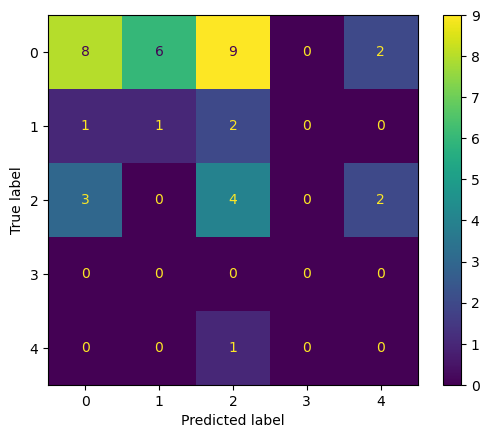

In [30]:
#docs_infra: no_execute
classes = [0, 1, 2, 3, 4]
#classes = [0, 1]
cm=confusion_matrix(y_test_def2, y_pred2,labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [33]:
from sklearn.metrics import classification_report
target_names = ['A', 'B+', 'B', 'B-','C']
print(classification_report(y_test_def2, y_pred2, target_names=target_names, digits=4))

ValueError: Number of classes, 4, does not match size of target_names, 5. Try specifying the labels parameter

In [ ]:
# model.save('modelos/modelote1203_200')  # creates a HDF5 file 'my_model.h5'

In [ ]:
#model.save('idea.h5')  # creates a HDF5 file 'my_model.h5'
model.save('modelos\modelo_perfecto_{}_{}.h5'.format(experimento,datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))) 

In [ ]:
#este modo de guardar no funciona en esta version de tensorflow
#model.save('modelos\modelo_perfecto_{}_{}'.format(experimento,datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))) 

In [ ]:
from scipy import stats
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_def)
#y_pred2 = scaler_out.inverse_transform(y_pred) #valor denormalizado

#y_pred1=y_pred[:,-1]
y_pred2=np.argmax(y_pred,axis=1)
n = len(y_pred2)
reshaped = y_pred2[:n//4*4].reshape(-1, 4)
mean_values = reshaped.mean(axis=1)

mean_values = np.round(mean_values)
mean_values = np.clip(mean_values, 0, 4)
mean_values = mean_values.astype(int)
print(mean_values)

mode_values = stats.mode(reshaped, axis=1)[0]
print(mode_values)

# Convierte los arrays a DataFrames
mean_df = pd.DataFrame(mean_values, columns=['mean'])
mode_df = pd.DataFrame(mode_values, columns=['mode'])

# Guarda los DataFrames en archivos Excel
mean_df.to_excel("excels_borrar\clasificacion_P1P2_mean_best7.xlsx", index=False)
mode_df.to_excel("excels_borrar\clasificacion_P1_mode_best7.xlsx", index=False)

3/3 [==============================] - 0s 30ms/step
[1 2 1 1 1 1 1 2 2 2 2 0 1 0 0 2 1 2 2 0 0 2]
[0 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0]


In [ ]:
print(y_pred2)

[0 1 0 2 2 2 2 4 0 0 4 0 0 0 4 0 0 0 2 2 0 1 2 0 1 2 0 0 4 2 0 0 2 2 4 0 0
 2 4 0 0 4 0 2 0 0 0 0 3 0 0 0 0 2 0 0 0 0 0 0 0 4 0 2 1 0 0 4 0 4 2 2 0 0
 4 2 2 0 0 0 2 0 0 0 2 4 0 0 0]


In [ ]:
filename5 = "COPIA_PANDAS\lomosP1_20240430_clasificado_experto.hdf"
with pd.HDFStore(filename5,complib="zlib",complevel=4) as hdf_db:
    pre_p_e2  = hdf_db.get('data/pollos_estado')
    pre_p_e2 = pre_p_e2.loc[pre_p_e2['Pollo'] != 0]
    pre_p_e2 =pre_p_e2.drop_duplicates(subset = ['Pollo', 'Medida'],  keep = 'last').reset_index(drop = True)
    t    = hdf_db.get('data/tabla')
    X_test2=np.zeros((pre_p_e2.shape[0],220,8))
    y_test2=np.zeros((pre_p_e2.shape[0],1))
    x=0
    for index, row in pre_p_e2.iterrows():   # El primer registro no se toma en cuenta porque es basura
        Primero = int(row['Primero'])
        Ultimo  = int(row['Ultimo'])
        estado  = int(row['Estado'])
        #print(Primero)
        #print(Ultimo)
        #print(estado)
        if estado == 0 or estado== 1:
           target = 1
        else:
           target = 0
        target=estado
        pepito=np.array(t.iloc[Primero:Ultimo+1])
        # #print(pepito.shape)
        X_test2[x]=pepito[:,3:11]
        #print(X_train[x][0:4,:])       
        y_test2[x]=target
        y_test2_to_categorical = to_categorical(y_test2)
        x=x+1


# print(X_train.shape)
# print(y_train_to_categorical.shape)
# #print(X_train[0:4,:,:])
# #print(X_train[1][0:4][:])
# print(y_train[1:20])
# print(y_train_to_categorical[1:20])
# # #Aqui filtrariamos si hay filas que no nos interesan. En este caso dejo pasar todos los casos
# print(p_e)
# # X_train_filtrado = X_train[2:][:,:]
# # y_train_filtrado = y_train[2:]
X_test2_filtrado = X_test2
#y_train_filtrado = y_train
y_test2_filtrado = y_test2_to_categorical

print(X_test2_filtrado.shape)
print(y_test2_filtrado.shape)
# print(X_train_filtrado[0][:,:])
# # # Vamos a normalizar o escalar los datos
# concatenamos train y test
#X_total=np.concatenate((X_train_filtrado,X_test_filtrado),axis=0)
#scaler = MinMaxScaler(feature_range=(0, 1))
#data_2d_test = X_total.reshape(-1, X_total.shape[-1])
data_2d_test = X_test2_filtrado.reshape(-1, X_test2_filtrado.shape[-1])
normalized_data_2d_test = scaler.transform(data_2d_test)


X_test2_def=normalized_data_2d_test.reshape(X_test2_filtrado.shape) 
# la alternativa es normalizar con el total
# X_test_def=normalized_data_2d_test.reshape(X_test_filtrado.shape) 

y_test2_def=y_test2_filtrado # los valores ya estaban normalizados

print(y_test2_def.shape)

print(y_test2_filtrado)

(200, 220, 8)
(200, 5)
(200, 5)
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 

In [ ]:
from scipy import stats
from sklearn.metrics import classification_report

# # Crear un nuevo modelo con la misma arquitectura
# best_val_model = create_model()  # Reemplaza esto con la función que usaste para crear el modelo original

# # Cargar los mejores pesos
# best_val_model.load_weights('best_weights.h5')

y_pred = model.predict(X_test2_def)
#y_pred2 = scaler_out.inverse_transform(y_pred) #valor denormalizado

#y_pred1=y_pred[:,-1]
y_pred2=np.argmax(y_pred,axis=1)
n = len(y_pred2)
print(n)
reshaped = y_pred2[:n//4*4].reshape(-1, 4)
mean_values = reshaped.mean(axis=1)

mean_values = np.round(mean_values)
mean_values = np.clip(mean_values, 0, 4)
mean_values = mean_values.astype(int)
print(mean_values.shape)

mode_values = stats.mode(reshaped, axis=1)[0]
print(mode_values.shape)

n = len(y_test2_def)
y_test2_def2=np.argmax(y_test2_def,axis=1)
print(y_test_def2.shape)
print(n)
reshaped2 = y_test2_def2[:n//4*4].reshape(-1, 4)
target_mean_values = reshaped2.mean(axis=1)

target_mean_values = np.round(target_mean_values)
target_mean_values = np.clip(target_mean_values, 0, 4)
target_mean_values = target_mean_values.astype(int)
print(target_mean_values.shape)

target_mode_values = stats.mode(reshaped2, axis=1)[0]
print(target_mode_values.shape)
print(reshaped)
print(mode_values)
print(target_mean_values)

7/7 [==============================] - 0s 27ms/step
200
(50,)
(50,)
(89,)
200
(50,)
(50,)
[[4 0 4 2]
 [0 0 0 4]
 [0 4 0 0]
 [0 0 2 2]
 [4 0 0 0]
 [0 0 4 0]
 [0 0 1 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 2]
 [0 0 0 0]
 [0 0 0 0]
 [0 2 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [2 0 0 0]
 [0 1 2 0]
 [0 0 0 0]
 [2 2 2 2]
 [3 0 0 0]
 [0 0 0 0]
 [0 0 2 0]
 [0 0 2 0]
 [2 0 0 0]
 [0 0 0 2]
 [0 0 0 0]
 [0 0 2 3]
 [0 2 0 0]
 [2 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [2 2 0 0]
 [3 2 0 4]
 [2 0 4 0]
 [0 0 4 0]
 [3 0 2 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 4 0 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 2 2]
 [0 0 1 0]
 [0 2 2 0]]
[4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 2 3 4 0 0 0 4 0 0 3 4 2 4 0 2 0 0 3 2 4 0 4 0 4 1 0 4 4 0 3 0 0 4 2 2
 3 0 0 4 0 2 0 0 4 4 0 0 2]


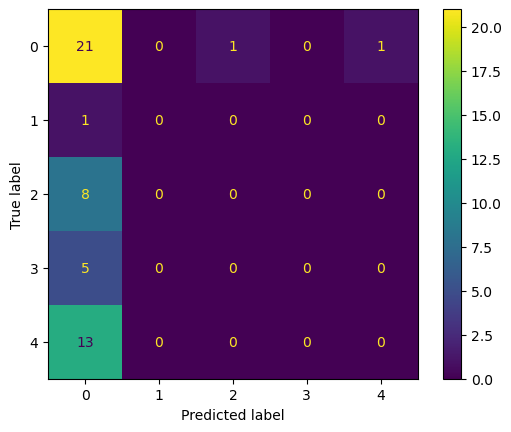

In [ ]:
#docs_infra: no_execute
classes = [0, 1, 2, 3, 4]
#classes = [0, 1]
cm=confusion_matrix(target_mode_values, mode_values,labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
print(cm.diagonal()/cm.sum(axis=1))

[0.91304348 0.         0.         0.         0.        ]


In [ ]:
target_names= ['A', 'B+', 'B', 'B-','C']
print(classification_report(target_mode_values, mode_values, target_names=target_names, digits=4))

              precision    recall  f1-score   support

           A     0.4375    0.9130    0.5915        23
          B+     0.0000    0.0000    0.0000         1
           B     0.0000    0.0000    0.0000         8
          B-     0.0000    0.0000    0.0000         5
           C     0.0000    0.0000    0.0000        13

    accuracy                         0.4200        50
   macro avg     0.0875    0.1826    0.1183        50
weighted avg     0.2013    0.4200    0.2721        50



c:\Users\rgadea\AppData\Local\miniconda3\envs\tensorflow_gpu_2024\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rgadea\AppData\Local\miniconda3\envs\tensorflow_gpu_2024\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rgadea\AppData\Local\miniconda3\envs\tensorflow_gpu_2024\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th